In [35]:
from itertools import product
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook

import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../../data/sensor1.csv')

In [3]:
df = df.dropna()

In [4]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [5]:
correlation = df.iloc[:, 1:].corr()
correlation

,CO2 (ppm),Humidity (%H),PM10 (μg/m³),PM2.5 (μg/m³),Temperature (°C),TVOC (ppm)
CO2 (ppm),1.000000,-0.249572,-0.144238,-0.148201,-0.404426,0.238779
Humidity (%H),-0.249572,1.000000,-0.113124,-0.117669,-0.107731,0.074451
PM10 (μg/m³),-0.144238,-0.113124,1.000000,0.996875,0.222147,-0.364539
PM2.5 (μg/m³),-0.148201,-0.117669,0.996875,1.000000,0.224113,-0.370432
Temperature (°C),-0.404426,-0.107731,0.222147,0.224113,1.000000,-0.136176
TVOC (ppm),0.238779,0.074451,-0.364539,-0.370432,-0.136176,1.000000


In [6]:
df['Time'] = pd.to_datetime(df['Time'])

In [7]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [8]:
df = df.sort_index()

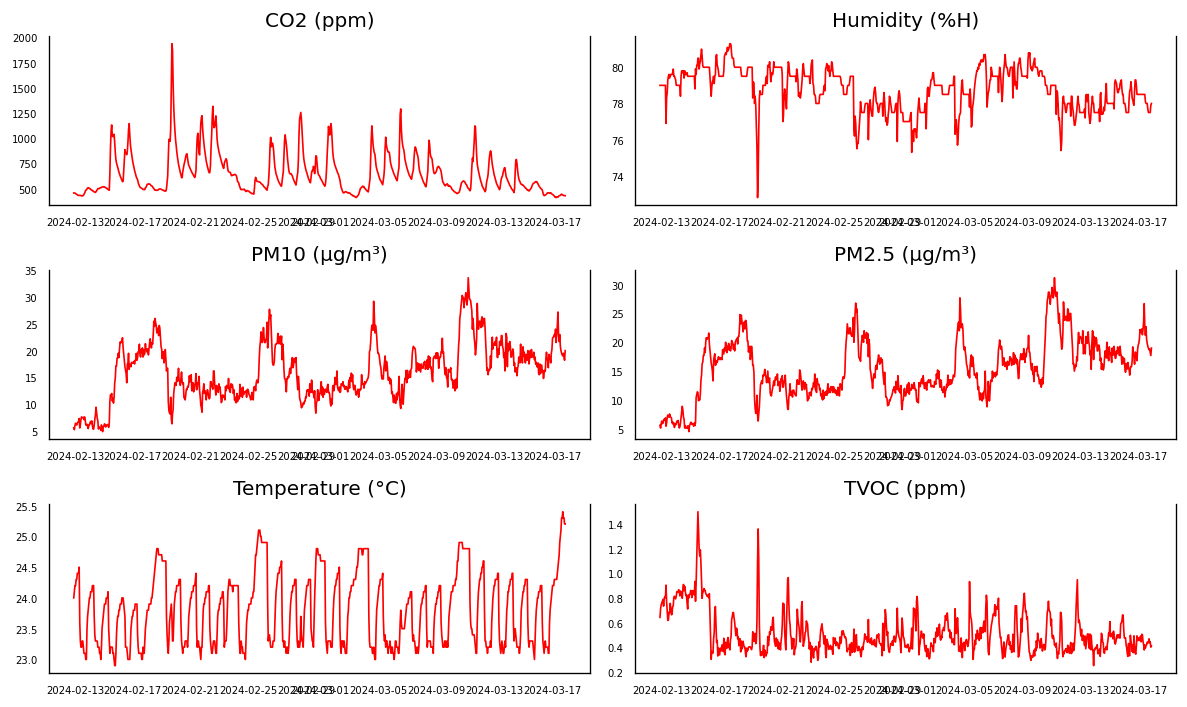

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [10]:
ad_fuller_result_1 = adfuller(df['Humidity (%H)'])
print('Humidity (%H)')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n----------------------\n')

ad_fuller_result_2 = adfuller(df['TVOC (ppm)'])
print('TVOC (ppm)')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Humidity (%H)
ADF Statistic: -5.687177578562321
p-value: 8.228063102944565e-07

----------------------

TVOC (ppm)
ADF Statistic: -4.059417384696599
p-value: 0.001129427487083918


< 0.05 so the data is stationary

Check if there is a correlation between these 2 variables

In [11]:
print('Humidity causes TVOC?\n')
print('-----------------------')
granger_1 = grangercausalitytests(df[['Humidity (%H)', 'TVOC (ppm)']], 4)

print('\nTVOC causes Humidity?\n')
print('-------------------------')
granger_2 = grangercausalitytests(df[['TVOC (ppm)', 'Humidity (%H)']], 4)

Humidity causes TVOC?

-----------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.8423 , p=0.0001  , df_denom=811, df_num=1
ssr based chi2 test:   chi2=14.8972 , p=0.0001  , df=1
likelihood ratio test: chi2=14.7625 , p=0.0001  , df=1
parameter F test:         F=14.8423 , p=0.0001  , df_denom=811, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.7144  , p=0.0002  , df_denom=808, df_num=2
ssr based chi2 test:   chi2=17.5367 , p=0.0002  , df=2
likelihood ratio test: chi2=17.3503 , p=0.0002  , df=2
parameter F test:         F=8.7144  , p=0.0002  , df_denom=808, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2688  , p=0.0013  , df_denom=805, df_num=3
ssr based chi2 test:   chi2=15.9440 , p=0.0012  , df=3
likelihood ratio test: chi2=15.7895 , p=0.0013  , df=3
parameter F test:         F=5.2688  , p=0.0013  , df_denom=805, df_num=3

Granger Causality
number of lags (no zero) 4
s

< 0.05 then the hypothesis is true

In [12]:
train_size = int(0.8 * len(df))

In [13]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [14]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [15]:
test_htvoc = df[df.index >= test_start_dt][['Humidity (%H)', 'TVOC (ppm)']]
train_htvoc = df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['Humidity (%H)', 'TVOC (ppm)']]

In [16]:
# test_htvoc_reshaped = test_htvoc.values.reshape(-1, 1)
# train_htvoc_reshaped = train_htvoc.values.reshape(-1, 1)

In [17]:
test_htvoc.shape

(163, 2)

In [18]:
train_htvoc.shape

(652, 2)

In [20]:
scaler = MinMaxScaler()
train_htvoc_scaled = scaler.fit_transform(train_htvoc)
train_htvoc_scaled = pd.DataFrame(train_htvoc_scaled, index=train_htvoc.index, columns=['Humidity (%H)', 'TVOC (ppm)'])
train_htvoc_scaled

,Humidity (%H),TVOC (ppm)
Time,,
2024-02-12 22:00:00,0.729412,0.297872
2024-02-12 23:00:00,0.729412,0.354337
2024-02-13 00:00:00,0.729412,0.381342
2024-02-13 01:00:00,0.729412,0.393617
2024-02-13 02:00:00,0.729412,0.406710
...,...,...
2024-03-10 23:00:00,0.729412,0.242226
2024-03-11 00:00:00,0.729412,0.285597
2024-03-11 01:00:00,0.729412,0.171031


In [21]:
test_htvoc_scaled = scaler.fit_transform(test_htvoc)
test_htvoc_scaled = pd.DataFrame(test_htvoc_scaled, index=test_htvoc.index, columns=['Humidity (%H)', 'TVOC (ppm)'])
test_htvoc_scaled

,Humidity (%H),TVOC (ppm)
Time,,
2024-03-11 04:00:00,0.923077,0.315186
2024-03-11 05:00:00,0.923077,0.240688
2024-03-11 06:00:00,0.923077,0.255014
2024-03-11 07:00:00,0.923077,0.217765
2024-03-11 08:00:00,0.512821,0.262178
...,...,...
2024-03-17 18:00:00,0.538462,0.312321
2024-03-17 19:00:00,0.538462,0.267908
2024-03-17 20:00:00,0.538462,0.275072


In [22]:
HORIZON_HUMIDITY = 1

Lag used is 1

In [23]:
model_htvoc = VAR(train_htvoc[1:])

In [24]:
sorted_order = model_htvoc.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.163      -3.149     0.04230      -3.158
1       -6.542     -6.499*    0.001442      -6.525
2       -6.567      -6.497    0.001406     -6.540*
3       -6.576      -6.478    0.001393      -6.538
4       -6.573      -6.446    0.001398      -6.523
5      -6.580*      -6.425   0.001388*      -6.519
6       -6.569      -6.386    0.001403      -6.498
7       -6.566      -6.354    0.001408      -6.484
8       -6.556      -6.316    0.001422      -6.463
9       -6.545      -6.277    0.001437      -6.441
10      -6.533      -6.237    0.001454      -6.419
11      -6.526      -6.202    0.001465      -6.400
12      -6.521      -6.168    0.001472      -6.384
13      -6.537      -6.157    0.001448      -6.390
14      -6.527      -6.118    0.001464      -6.368
15      -6.515      -6.078    0.001482      -6.345
16      -6.506      -6.040    0

Minimum AIC and minimum FPE is found on Lag 5 so it used be used to build the model.

In [25]:
var_model = VARMAX(train_htvoc, order=(5,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:     ['Humidity (%H)', 'TVOC (ppm)']   No. Observations:                  652
Model:                                      VAR(5)   Log Likelihood                 315.645
                                       + intercept   AIC                           -581.290
Date:                             Sun, 17 Mar 2024   BIC                           -469.289
Time:                                     23:47:31   HQIC                          -537.854
Sample:                                          0                                         
                                             - 652                                         
Covariance Type:                               opg                                         
Ljung-Box (L1) (Q):             0.01, 0.00   Jarque-Bera (JB):     4162.82, 1928.61
Prob(Q):                        0.92, 0.97   Prob(JB):                   0.00, 0.00
Hete

In [26]:
test_htvoc_shifted = test_htvoc_scaled.copy()

for t in range(1, HORIZON_HUMIDITY):
    test_htvoc_shifted["Humidity (%H)+" + str(t)] = test_htvoc_shifted["Humidity (%H)"].shift(-t, freq='H')
    test_htvoc_shifted["TVOC (ppm)+" + str(t)] = test_htvoc_shifted["TVOC (ppm)"].shift(-t, freq='H')
    
test_htvoc_shifted = test_htvoc_shifted.dropna(how='any')
test_htvoc_shifted.head()

,Humidity (%H),TVOC (ppm)
Time,,
2024-03-11 04:00:00,0.923077,0.315186
2024-03-11 05:00:00,0.923077,0.240688
2024-03-11 06:00:00,0.923077,0.255014
2024-03-11 07:00:00,0.923077,0.217765
2024-03-11 08:00:00,0.512821,0.262178


In [27]:
%%time
training_window = 168

train_ts_htvoc = train_htvoc_scaled[["Humidity (%H)", "TVOC (ppm)"]]
test_ts_htvoc = test_htvoc_shifted

history_htvoc = train_ts_htvoc.iloc[-training_window:].values.tolist()

predictions_htvoc = []

for t in range(len(test_ts_htvoc)):
    model_htvoc = VARMAX(endog=history_htvoc, order=(5, 0), enforce_stationarity=True)
    model_fit_htvoc = model_htvoc.fit(disp=False)
    yhat = model_fit_htvoc.forecast(steps=1)
    yhat_flat = [item for sublist in yhat for item in sublist]
    predictions_htvoc.extend(yhat_flat)
    obs = test_ts_htvoc.iloc[t].values.tolist()
    # Move the training window
    history_htvoc.append(obs)
    history_htvoc.pop(0)
    print(test_ts_htvoc.index[t])
    print(t+1, ': predicted =', yhat_flat, 'expected =', obs)

2024-03-11 04:00:00
1 : predicted = [0.7409634146233511, 0.1703168124998461] expected = [0.9230769230769234, 0.3151862464183381]
2024-03-11 05:00:00
2 : predicted = [0.9553892034128318, 0.3257840137229611] expected = [0.9230769230769234, 0.24068767908309457]
2024-03-11 06:00:00
3 : predicted = [0.8340353322195503, 0.2980032052180735] expected = [0.9230769230769234, 0.25501432664756446]
2024-03-11 07:00:00
4 : predicted = [0.9032445651112355, 0.26018457080956137] expected = [0.9230769230769234, 0.21776504297994276]
2024-03-11 08:00:00
5 : predicted = [0.8918728574254082, 0.20573570162924568] expected = [0.5128205128205146, 0.2621776504297994]
2024-03-11 09:00:00
6 : predicted = [0.47394433040872685, 0.2111835903873885] expected = [0.8461538461538467, 0.1475644699140401]
2024-03-11 10:00:00
7 : predicted = [0.9024130841034287, 0.11425343499917541] expected = [0.8205128205128212, 0.0830945558739255]
2024-03-11 11:00:00
8 : predicted = [0.7355524832037362, 0.12134339777648459] expected = [

In [28]:
predictions_htvoc_reshaped = np.array(predictions_htvoc).reshape(-1, 2)
eval_df_htvoc = pd.DataFrame(predictions_htvoc_reshaped, columns=['Humidity_Prediction', 'TVOC_Prediction'])
eval_df_htvoc.insert(0, 'Time', test_htvoc_scaled.index[0:len(test_htvoc_scaled.index)-HORIZON_HUMIDITY+1])
eval_df_htvoc['Humidity_Actual'] = np.array(np.transpose(test_ts_htvoc['Humidity (%H)'])).ravel()
eval_df_htvoc['TVOC_Actual'] = np.array(np.transpose(test_ts_htvoc['TVOC (ppm)'])).ravel()
eval_df_htvoc[['Humidity_Actual', 'TVOC_Actual']] = scaler.inverse_transform(eval_df_htvoc[['Humidity_Actual', 'TVOC_Actual']])
eval_df_htvoc[['Humidity_Prediction', 'TVOC_Prediction']] = scaler.inverse_transform(eval_df_htvoc[['Humidity_Prediction', 'TVOC_Prediction']])

eval_df_htvoc.head()

,Time,Humidity_Prediction,TVOC_Prediction,Humidity_Actual,TVOC_Actual
0,2024-03-11 04:00:00,78.289757,0.368881,79.0,0.470
1,2024-03-11 05:00:00,79.126018,0.477397,79.0,0.418
2,2024-03-11 06:00:00,78.652738,0.458006,79.0,0.428
3,2024-03-11 07:00:00,78.922654,0.431609,79.0,0.402
4,2024-03-11 08:00:00,78.878304,0.393604,77.4,0.433


In [29]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [30]:
print('Multi-step forecast MAPE: ', mape(eval_df_htvoc['TVOC_Prediction'], eval_df_htvoc['TVOC_Actual'])*100, '%')

Multi-step forecast MAPE:  11.379766215127574 %


In [36]:
rmse_tvoc = sqrt(mean_squared_error(eval_df_htvoc['TVOC_Prediction'], eval_df_htvoc['TVOC_Actual']))
rmse_tvoc

0.06720669839862585

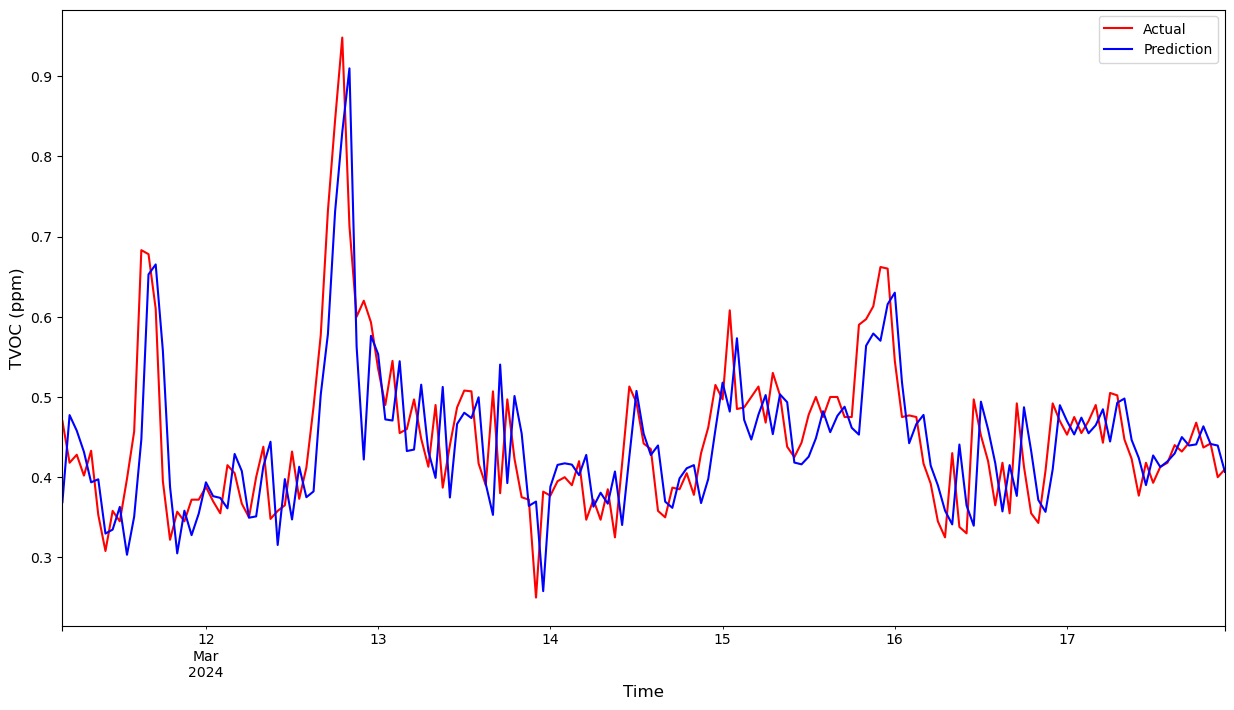

In [37]:
eval_df_htvoc.plot(x='Time', y=['TVOC_Actual', 'TVOC_Prediction'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('Time', fontsize=12)
plt.ylabel('TVOC (ppm)', fontsize=12)
plt.legend(['Actual', 'Prediction'], loc='best')
plt.show()

In [38]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [39]:
pred_tvoc = model_fit_htvoc.predict(start=len(df), end=len(df), typ="levels")[0]
pred_tvoc_nonscaled = round(scaler.inverse_transform(np.array(pred_tvoc).reshape(1, 2))[0][1], 4)
print(f"{next_hour} {pred_tvoc_nonscaled}")

2024-03-17 23:00:00 0.4485
